# Data Model Evaluation with SHAP Values
* In the presented notebook we will try to get more insights and understand what our model is doing. Check the importance of features, its sign and its effect on our target variable Rreproduction rate.

## Import Libraries

In [469]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
import shap
import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pickle

## Authenticate to Google Drive 
(Request access to lucasbotellaroca@gmail.com if not conceded)
Retrieve all files from different folders

In [413]:
# A browser window will open. Login using the appropriate account.
gauth = GoogleAuth()
gauth.LocalWebserverAuth() #

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=267819126046-3da5rmgml4iemor49ermcv23tnaj02t5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [414]:
drive = GoogleDrive(gauth)

In [415]:
drive

## Auxiliary Functions

In [416]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(reg2_gbr)
    shap_values_Model = explainerModel.shap_values(X_train_appch2_clean)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train_appch2_clean.iloc[[j]])
    return(p)

In [417]:
def read_csv_file(folder, fileName, nrows):
    
    read_file = drive.ListFile({'q': "title contains '" + fileName + ".csv' and '" + folder + "' in parents"}).GetList()
    
    if len(read_file)>0:
        title = read_file[0]['title']
        id = read_file[0]['id']
        each_file = drive.CreateFile({'id': id})
        each_file.GetContentFile(title)
        df = pd.read_csv(title, skiprows=nrows)
    else:
        
        df=pd.DataFrame()
    
    return df

## Read File and Prepare Data

* Same transofrmation as in the data model notebook is performed. 

In [418]:
#df=pd.read_csv('df_covid_processed_final_reproduction_rate.csv')
df=read_csv_file('1EsuOqiCqQK5HSCI3aPOvOUq2kXsXd5uH','df_covid_processed_final_reproduction_rate',0)

#Selected columns for our analysis
df=df[['Code', 'Date', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'contact_tracing', 
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', 'youth_unemployment','infections_value',
      'accumulated', 'reproduction_rate']]

df = df[df['infections_value'].notna()]
df = df[df['accumulated'].notna()]
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['infections_value'][df['infections_value'] < 0] = 0

df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,income_support,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,AUS,2020-03-22,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,0.000000,0.0,...,0.0,21.346512,0.142010,8263000.0,85.904,0.000000,11.84,7.28,0.002502,2.170000
1,AUS,2020-03-29,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,0.000000,1.0,...,0.0,21.176835,0.054789,8263000.0,85.904,0.000000,11.84,12.13,0.003071,2.330000
2,AUS,2020-04-05,-10.591857,22.020286,5.102143,-21.836714,-14.836714,-0.918286,0.285714,1.0,...,0.0,20.702945,0.051898,8263000.0,85.904,0.000000,11.84,11.31,0.003808,2.280000
3,AUS,2020-04-12,-32.163429,-0.020429,13.428429,-48.775571,-28.183714,-22.816286,2.000000,1.0,...,0.0,21.093375,0.073336,8263000.0,85.904,0.000000,11.84,6.36,0.005034,1.457143
4,AUS,2020-04-19,-40.918429,-12.347143,17.612143,-60.204143,-39.326571,-35.265286,2.000000,1.0,...,0.0,18.880697,0.118556,8263000.0,85.904,0.000000,11.84,2.95,0.006178,0.765714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,USA,2021-01-31,-24.673429,-12.857143,10.795714,-40.183714,-19.183714,-28.816286,1.000000,2.0,...,1.0,3.141409,0.027324,75608000.0,82.058,4.160000,8.30,28.11,0.217541,0.892857
3573,USA,2021-02-07,-25.836714,-14.142714,10.734429,-41.285714,-21.000143,-28.816143,1.000000,2.0,...,0.0,1.441940,0.060531,75608000.0,82.058,6.405714,8.30,25.01,0.223260,0.848571
3574,USA,2021-02-14,-25.938714,-14.551000,10.714000,-41.714286,-25.775714,-27.938714,1.000000,2.0,...,0.0,0.586187,0.055322,75608000.0,82.058,9.125714,8.30,15.60,0.228214,0.825714
3575,USA,2021-02-21,-24.489857,-12.326571,10.142857,-40.591714,-23.285714,-27.489714,1.000000,2.0,...,0.0,-1.192456,0.032941,75608000.0,82.058,12.074286,8.30,12.85,0.232621,0.780000


In [419]:
df_appch2=df.copy()

Grouping of variables based on previous knowledge adquired in the data exploration section.

* Variables grouped as **mobility_index** are variables that have a positive relation in the spread of the virus. Those variables are "retail_and_recreation", "transit_stations", "grocery_and_pharmacy", "workplaces". They have been ponderated to an approximation of more or less effect on the response variable.

* Variables grouped as **awareness_measures** are variables that represent the conciency and awareness given from governments to the population, most meaningful one is "facial_coverings".

* Variables grouped as **economic_measures** are measures that support debt and income, which prevents workers from going to work and thus decreasing mobility and activity.

* Variables grouped as **health_measures** are measures that support tracing and testing of cases.

* Variables grouped as **mobility_measures** are measures that limit mobility and interactions between individuals of different households and cities. 

* Variables grouped as **closure_measures** are measures that limit usual work and school life together with events.

There are some other variables such as: 'residential', 'holiday', 'temp', 'prcp','number_of_arrivals', 'urban_population','total_vaccinations_per_100', 'youth_unemployment','infections_value', 'accumulated' are not modified nor grouped since they appear to be independent from each other and its effect on the response variable.

In [420]:
df_appch2['mobility_index']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.4
                           +df_appch2['grocery_and_pharmacy']*0.1+df_appch2['workplaces']*0.1)

df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_measures']=0.3*df_appch2['stay_home_requirements']\
                                + 0.3*df_appch2['restriction_gatherings']\
                                + 0.2*df_appch2['restrictions_internal_movements']\
                                + 0.1*df_appch2['international_travel_controls']\
                                + 0.1*df_appch2['close_public_transport']\
                    

df_appch2['closure_measures'] = 0.2*df_appch2['cancel_public_events']\
                                + 0.4*df_appch2['workplace_closures']\
                                + 0.4*df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date','mobility_index', 'residential',
                     'awareness_measures', 'health_measures',
                     'mobility_measures', 'economic_measures',
                     'closure_measures',
                     'holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                     'total_vaccinations_per_100', 'youth_unemployment',
                     'infections_value', 'accumulated', 'reproduction_rate']]

In [421]:
date=pd.Timestamp(2021, 1, 10)
X_1_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) <= date)]
X_2_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch2_clean[df_appch2_clean.columns[2:-1]])

X_train_appch2_clean = pd.DataFrame(scaler.transform(X_1_clean[X_1_clean.columns[2:-1]]), columns=df_appch2_clean.columns[2:-1])
X_test_appch2_clean = pd.DataFrame(scaler.transform(X_2_clean[X_2_clean.columns[2:-1]]), columns=df_appch2_clean.columns[2:-1])

y_train_appch2_clean=X_1_clean['reproduction_rate']
y_test_appch2_clean=X_2_clean['reproduction_rate']

In [473]:
X_train_appch2_clean.columns

Index(['mobility_index', 'residential', 'awareness_measures',
       'health_measures', 'mobility_measures', 'economic_measures',
       'closure_measures', 'holiday', 'temp', 'prcp', 'number_of_arrivals',
       'urban_population', 'total_vaccinations_per_100', 'youth_unemployment',
       'infections_value', 'accumulated'],
      dtype='object')

## Import Models and Evaluate Shap Values
We will perform evaluation and analysis of the impact of variables on the training set predictions (year 2020).

In [426]:
pickle_file='./model_lgbm_reg'
reg2_gbr = pickle.load(open(pickle_file,'rb'))
reg2_gbr.fit(X_train_appch2_clean, y_train_appch2_clean)
y_pred_2=reg2_gbr.predict(X_test_appch2_clean)
y_pred_train_2=reg2_gbr.predict(X_train_appch2_clean)

### Tree explainer Bar Plot
We will plot our feature importance bar plot, this will represent the importance of each feature in terms of predictions of our target variable reproduction_rate

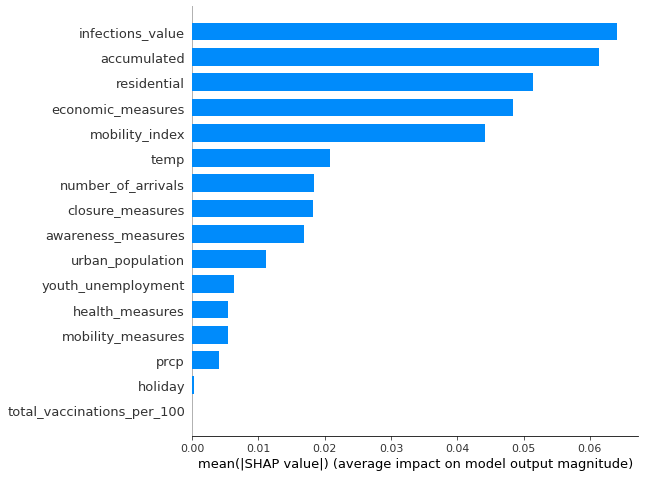

In [427]:
shap_values = shap.TreeExplainer(reg2_gbr).shap_values(X_train_appch2_clean)
shap.summary_plot(shap_values, X_train_appch2_clean, plot_type="bar")

* As seen variables that seem to have a higher impact on our target variable reproduction rate are:
    * **infectious_value** which represents the amount of current people infecting
    * **accumulated** which represents the amount of people that have already contracted the virus
    * **residentail** which represents the amount of time people spend time at home
    * **economic_measures** which represents the economic support given by governments in terms of debt relief and income support
    * **mobility_index** which represents the mobility increase or decrease in reatil and recreation, transit stations, groceries, pharmacy and workplaces

* Other variables that have smaller coefficients are **temperature, number of arrivals, closure measures, awareness measures and urban population**

## Generalization of shap values
* Code extracted from (https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

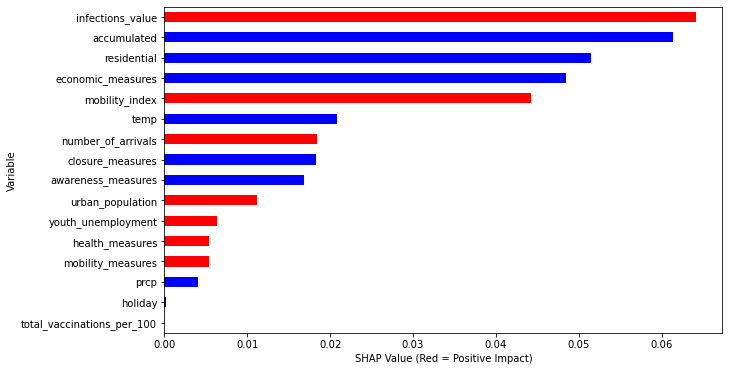

In [432]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train_appch2_clean)

* In blue we can see variables that have negative sign or negative impact on the increase of reproduction rate and on red we can see variables that have positive sign or positive impact on our target variable.

* There some unexpected values such as health_measures and mobility_measures that seem tobe positive for the virus, we will analyze those separetly.


### Tree explainer Plot

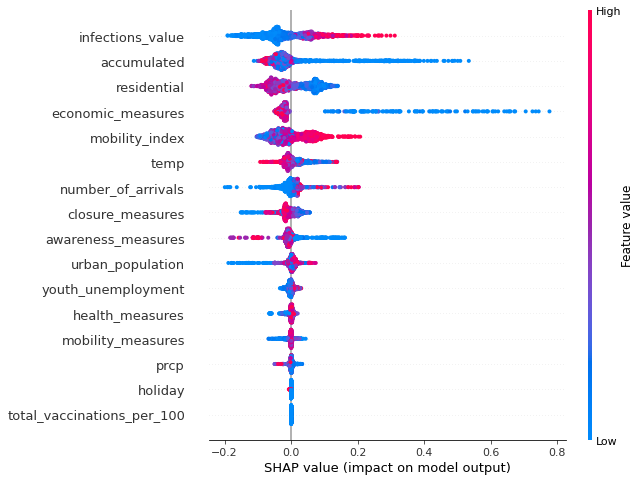

In [458]:
explainer = shap.TreeExplainer(reg2_gbr)
shap_values = explainer.shap_values(X_train_appch2_clean)
shap.summary_plot(shap_values, X_train_appch2_clean)

We will perform a resume of the variables and its impact on our traget vairable **reproduction rate**

> **infections_value** which represents the amount of current people infecting.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.

> **accumulated** which represents the amount of current people infecting.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.

> **residential** which represents the amount of time people spend time at home.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    
> **economic_measures** which represents the economic support given by governments in terms of debt relief and income support.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.

> **mobility_index** which represents the mobility increase or decrease in retail and recreation, transit stations, groceries, pharmacy and workplaces.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.
    
> **temp** which represents the average temperature in the deferred week.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    
> **number_of_arrivals** which is the usual number of tourists received but that represnets countries with high or small mobility worldwise.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.

> **closure_measures** which are the restrictions in closings applied by governments.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    > However there are some very low values related with negative impact. Will analyze it more in detail later on.
    
> **awareness_measures** which are variables that represent the conciency and awareness given from governments to the population, most meaningful one is "facial_coverings".
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    > However there are some very low values related with negative impact. Will analyze it more in detail later on.
    
> **urban_population** which is an indicator ot he percentage of people that live in urban areas and that tries to simulate population density.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.
    > However there are some very low values related with negative impact. Will analyze it more in detail later on.
    
* The rest of the coefficients seem to have little influence in the target variable and the coeficients and importance of those variable may be absorved by some other variables previously mentioned. 

However based on the grap it can be esimated that:

* **youth unemployment** is related with reproduction rate positively.
* **precipitations** are related with reproduction rate negatively.
* **holiday** are related with reproduction rate positively on holidays with high values, however low values of holiday don´t seem to have impact on the response variable.


Some other variables may have such coefficients due to multicollinearity with other variables, based on the correlation matrix shown below. In order to detect this multicollinearity issues will analyze each of this features separately and its possible relation with some other more dominant features.

<AxesSubplot:>

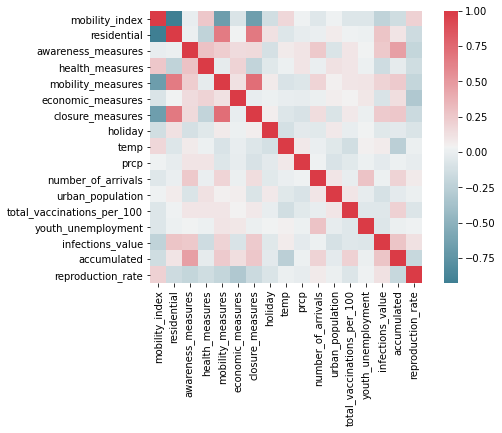

In [471]:
f, ax = plt.subplots(figsize=(8, 5))
corr = df_appch2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

* Mobility index and residential are positive related with mobility measures and closure measures respectively, and inverse between themselves.

## Single Variables Dependence Plots Analysis

##### mobility_measures

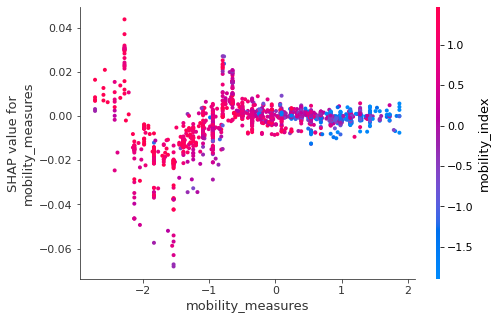

In [402]:
shap.dependence_plot("mobility_measures", shap_values, X_train_appch2_clean, interaction_index="mobility_index")

* As seen mobility_measures have a relation with mobility index, therefore on the previous plots analyzed the imapct of this variable is not really positive, it is just that vairable "mobility_index" has captured its effect. This can be seen in the graph, low values of mobility_measures are related with high values in mobility_index which in fact affect the positive increase of reproduction rate. High values of mobility measures are related with low values of mobility_index and therefore negative impact on the response variable.

##### health_measures

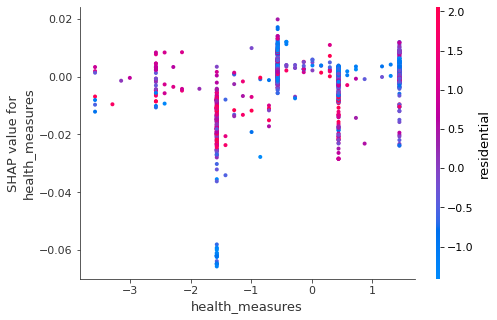

In [448]:
shap.dependence_plot("health_measures", shap_values, X_train_appch2_clean)

<AxesSubplot:>

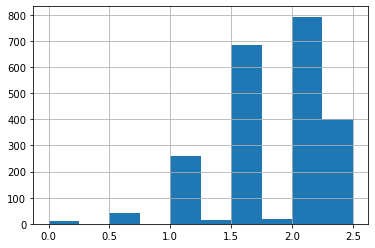

In [453]:
df_appch2.health_measures.hist()

* This variabel doesn't seem to have relation with any other feature in the dataset, This variabel reflects government pursue on public information campaigns and measures on facial coverings. 
* This is due to the fact that as seen on the histogram, this measures seemed to be applied all over the pandemic, therefore its impact maynot be properly reflected, since this variable has mostly high values in entries of the dataset.

In [455]:
df_appch2.columns

Index(['Code', 'Date', 'mobility_index', 'residential', 'awareness_measures',
       'health_measures', 'mobility_measures', 'economic_measures',
       'closure_measures', 'holiday', 'temp', 'prcp', 'number_of_arrivals',
       'urban_population', 'total_vaccinations_per_100', 'youth_unemployment',
       'infections_value', 'accumulated', 'reproduction_rate'],
      dtype='object')

##### total_vaccinations_per_100

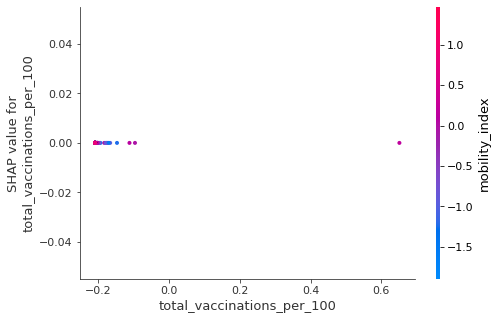

In [456]:
shap.dependence_plot("total_vaccinations_per_100", shap_values, X_train_appch2_clean, interaction_index="mobility_index")

* This variable is of course predicticably the variable that should predict the most together with accumulated and infections, in fact it should ahve the same effect as accumulated, however since there is ver yfew data collected for train of the model since vaccinations started in 2021 approximately, the model is not including it as an important feature, however in future analysis with more amount of data this variable will predictably have the same weight as accumulated.

##### prcp 

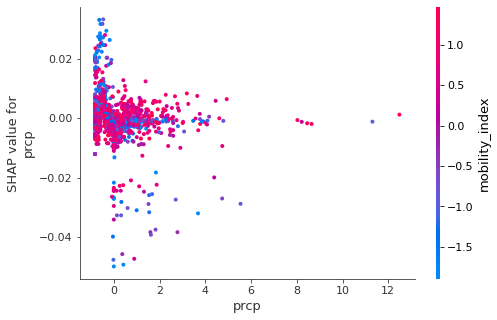

In [460]:
shap.dependence_plot("prcp", shap_values, X_train_appch2_clean, interaction_index="mobility_index")

* We can see that precipitations don't seem to have relation with the mobility index. Howver it does seem t0 have negative impact on the target variable base on tree explainer plot meaning, high values are related with low values of reproduction rate

## Quick look over some predictions

In [434]:
shap_plot(0)

In [441]:
shap_plot(8)

In [442]:
shap_plot(20)

In [443]:
shap_plot(90)